# Quick start for working with the combinatorial library

In [1]:
from pathlib import Path
import pickle
import sys

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.PropertyMol import PropertyMol
Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)

import kinase_focused_fragment_library as kffl
import klifs_utils as klifs

RDKit WARNING: [15:47:22] Enabling RDKit 2019.09.3 jupyter extensions


In [50]:
PROJECT_PATH = Path('/home/dominique/Documents/Projects/')

FRAGMENT_LIBRARY_PATH = PROJECT_PATH / 'KinaseFocusedFragmentLibraryData' / 'FragmentLibrary'
COMBINATORIAL_LIBRARY_PATH = PROJECT_PATH / 'KinaseFocusedFragmentLibraryData' / 'CombinatorialLibrary'

SUBPOCKETS = ['AP', 'FP', 'SE', 'GA', 'B1', 'B2']

In [42]:
sys.path.append(str(PROJECT_PATH / 'KinaseFocusedFragmentLibrary' / 'kinase_focused_fragment_library' / 'analysis' / 'ligand_analysis'))
from construct_ligand import construct_ligand, read_fragment_library
from standardize import standardize_mol
from combinatorial_library_pickle2text import get_combinatorial_library_data

sys.path.append(str(PROJECT_PATH / 'KinaseFocusedFragmentLibrary' / 'kinase_focused_fragment_library' / 'recombination'))
from pickle_loader import pickle_loader

## Load (reduced) fragment library

In [11]:
fragment_library = kffl.analysis.fragment_analysis.util.read_fragment_library(
    FRAGMENT_LIBRARY_PATH, 
    remove_dummy=True, 
    reduced='_reduced_0.6'
)
del fragment_library['X']  # This pool contains only fragments without subpocket assignment

In [12]:
fragment_library.keys()

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2'])

In [56]:
fragment_library['AP'].head()

,smiles,fragment,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,klifs_code,atom.prop.subpocket,atom.prop.environment
0,c1cnc2[nH]c3cnccc3c2c1,<rdkit.Chem.rdchem.Mol object at 0x7f14247b4f30>,CHK1,CAMKL,CAMK,4qyg,3DW,,A,4qyg_chainA,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 1...
1,Nc1cccc2ncccc12,<rdkit.Chem.rdchem.Mol object at 0x7f1424292b70>,PIM1,PIM,CAMK,5mzl,8ET,A,A,5mzl_altA_chainA,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,16 16 16 16 16 16 5 5 16 16 16 16 16 16 16 16 ...
2,Nc1nc(N)c2ncccc2n1,<rdkit.Chem.rdchem.Mol object at 0x7f14247b4f80>,IRAK4,IRAK,TKL,6rfj,K1E,,A,6rfj_chainA,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,14 14 14 14 14 14 14 14 14 5 5 14 14 14 5 5 na...
3,Cc1cnc2ccnn2c1N,<rdkit.Chem.rdchem.Mol object at 0x7f14247b4da0>,CDK2,CDK,CMGC,3wbl,PDY,,A,3wbl_chainA,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,16 16 8 8 8 8 16 16 16 16 16 16 16 16 16 5 5 n...
4,c1ccc2[nH]ncc2c1,<rdkit.Chem.rdchem.Mol object at 0x7f1424292990>,BARK1,GRK,AGC,5he1,ZS2,A,A,5he1_altA_chainA,AP AP AP AP AP AP AP AP AP AP AP AP AP AP FP,16 16 16 16 16 16 16 16 16 16 16 16 16 16 na


## Load original ligands

In [14]:
# Get deduplicated kinase-structure pairs
kinase_structure_pairs = kffl.analysis.fragment_analysis.util.get_deduplicated_original_complexes(fragment_library)
kinase_structure_pairs['species'] = 'HUMAN'

# Get ligands
original_ligands = klifs.ligands.mols_from_mol2s(PROJECT_PATH / 'KinaseFocusedFragmentLibraryData', kinase_structure_pairs)

Fragments: 801
Deduplicated kinase-structure pairs from which fragments originate: 694


## Load and work with recombined ligands

Initially, Paula saved the combinatorial library as `pickle` file. 

Since this format apparently cannot be read in any more after making structural changes to the the code (refactoring the code to be used as library), the pickled data was reformatted and saved as text files additionally.

* `pickle` file
  * `combinatorial_library.pickle`
  
* text files
  * `combinatorial_library_fragment_bonds.json`
  * `combinatorial_library_fragment_ids.json`
  * `combinatorial_library_properties.csv`

### Use `pickle` file

In [32]:
combinatorial_library_path = COMBINATORIAL_LIBRARY_PATH / 'combinatorial_library.pickle'

#### Perform calculations on each ligand

Reading *and* storing all ligands takes a lot of memory, therefore any calculations needed to be done on all ligands should be done within this for-loop.

#### Read in a single specific ligand

In [34]:
with open(combinatorial_library_path, 'rb') as pickle_file:
    
    # first ligand
    for i in range(1):
        ligand = next(pickle_loader(pickle_file))

#### Read in several ligands from a given list of ligand IDs (sorted ascendingly!):

In [30]:
ligand_ids = [345, 83759, 3509547]

In [35]:
ligands = []

counter = 0
current_id = ligand_ids[counter]

with open(combinatorial_library_path, 'rb') as pickle_file:
    
    for i in range(max(ligand_ids)):
        ligand = next(pickle_loader(pickle_file))
        
        current_id = ligand_ids[counter]
        # store ligand corresponding to an ID in ligand_ids in list of ligands
        if i == current_id-1:
            print(current_id)
            ligands.append(ligand)
            counter += 1

345
83759
3509547


In [36]:
ligands

### Work with ligands

Example ligand for cells below: Fenclozic acid (3509547).

In [37]:
ligand = ligands[2]

#### Access ligand properties

In [38]:
vars(ligand)

{'meta': <classes_meta.Combination at 0x7f142321be10>,
 'n_subpockets': 3,
 'lipinski': 1,
 'mwt': 1,
 'logp': 1,
 'hbd': 1,
 'hba': 1,
 'n_atoms': 16,
 'original': 0,
 'original_sub': 0,
 'chembl_match': 1}

In [39]:
# metadata containing information which fragments need to be connected at which bond
vars(ligand.meta)

{'frag_ids': frozenset({'AP_213', 'GA_51', 'SE_41'}),
 'bonds': frozenset({frozenset({'AP_6', 'SE_7'}),
            frozenset({'AP_5', 'GA_4'})})}

#### Generate a molecule object for this ligand and standardize the molecule

In [51]:
fragment_library_mols = read_fragment_library(FRAGMENT_LIBRARY_PATH, SUBPOCKETS)

Number of fragments in AP : 230
Number of fragments in FP : 254
Number of fragments in SE : 160
Number of fragments in GA : 100
Number of fragments in B1 : 23
Number of fragments in B2 : 34


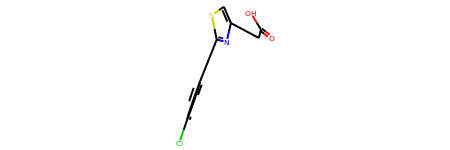

In [52]:
mol = standardize_mol(construct_ligand(ligand.meta, fragment_library_mols))
mol

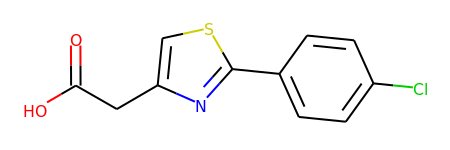

In [53]:
AllChem.Compute2DCoords(mol)
mol

#### Subpocket and KLIFS metadata

To which subpockets were the fragments assigned and from which ligands do the fragment originate?

In [54]:
highlightAtomLists = []
legends = []

for subpocket in SUBPOCKETS:
    highlight_atoms = []
    legend = subpocket
    
    for atom in mol.GetAtoms():
        
        if atom.HasProp('subpocket'):
            
            if atom.GetProp('subpocket') == subpocket:
                
                highlight_atoms.append(atom.GetIdx())
                legend = subpocket + ': '+atom.GetProp('frag_id')
    
    highlightAtomLists.append(highlight_atoms)
    legends.append(legend)

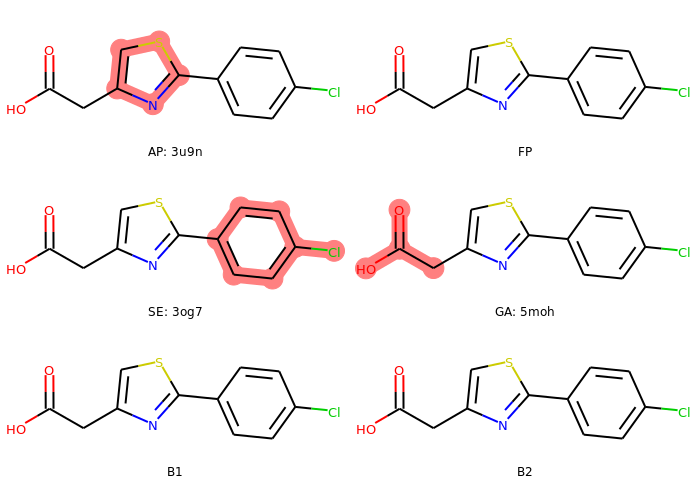

In [55]:
Draw.MolsToGridImage([mol, mol, mol, mol, mol, mol], 
                     highlightAtomLists=highlightAtomLists, legends=legends, molsPerRow=2, subImgSize=(350, 160))